### XGBoost, Multiclass Classification Evaluation and Model Dump

In [1]:
import numpy as np
import pandas as pd
from itertools import cycle

from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy import interp

from xgboost import XGBClassifier

rng = 3691

In [2]:
n_classes = 5

In [3]:
x, labels = make_classification(n_samples=10_000, 
                                n_informative=10, 
                                n_classes=n_classes, 
                                weights=[0.1,0.2,0.3,0.2],
                                random_state=rng)
np.unique(labels)

array([0, 1, 2, 3, 4])

In [4]:
import pandas as pd
df = pd.read_parquet('/home/jovyan/data/classifier-data.parquet')

In [5]:
x = df.values[:,:-2]
labels = df.values[:,-1]
np.unique(labels)

array([0., 1., 2., 3., 4.])

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x, labels)

In [7]:
clf = XGBClassifier(n_classes=n_classes, random_state=rng, objective="multi:softmax")

In [8]:
clf_p = XGBClassifier(n_classes=n_classes, random_state=rng, objective="multi:softprob")

In [9]:
def gen_xgb_model(model_type: str, xgb_params: dict):
    """generate an xgboost model
    
    Multiple model types that can be estimated using
    the XGBoost Scikit-Learn API.
    
    Input can either be a predefined json model configuration or one
    of the five xgboost model types: "classifier", "regressor", "ranker",
    "rf_classifier", or "rf_regressor".
    
    In either case one can pass in a params dict to modify defaults values.
    
    Based on `mlrun.mlutils.models.gen_sklearn_model`, see the function
    `sklearn_classifier` in this repository.
    
    :param model_type: one of "classifier", "regressor",
                       "ranker", "rf_classifier", or
                      "rf_regressor"
    :param xgb_params: class init parameters
    """
    from mlrun.mlutils import get_class_fit, gen_sklearn_model

    # generate model and fit function
    mtypes = {
        "classifier"   : "xgboost.XGBClassifier",
        "regressor"    : "xgboost.XGBRegressor",
        "ranker"       : "xgboost.XGBRanker",
        "rf_classifier": "xgboost.XGBRFClassifier",
        "rf_regressor" : "xgboost.XGBRFRegressor"
    }
    if model_type.endswith("json"):
        model_config = model_type
    elif model_type in mtypes.keys():
        model_config = mtypes[model_type]
    else:
        raise Exception("unrecognized model type, see help documentation")

    return gen_sklearn_model(model_config, xgb_params)

In [10]:
from  mlrun.mlutils import (get_sample,
                            get_splits,
                            gen_sklearn_model,
                            create_class, 
                            eval_class_model)
from mlrun.execution import MLClientCtx
from mlrun.datastore import DataItem
from cloudpickle import dumps

model_config = gen_xgb_model("classifier", {})
model_short_name = model_config["META"]["class"].split('.')[-1]
model_config["CLASS"]["objective"] = "multi:softmax"
model_config["CLASS"]["n_classes"] = 5
model_config["CLASS"]["n_jobs"] = -1
model_config["CLASS"]["max_depth"] = 200

XGBBoostClass = create_class(model_config["META"]["class"])
model = XGBBoostClass(**model_config["CLASS"])

In [11]:
model

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=200,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_classes=5, n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              objective='multi:softmax', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [12]:
model.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=200,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_classes=5, n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

In [13]:
#clf_p.fit(xtrain, ytrain)

### objective="multi:softmax"

In [14]:
ypred = model.predict(xtest)
ypred

array([3., 2., 3., ..., 3., 2., 2.])

In [15]:
yprob = model.predict_proba(xtest)
yprob

array([[1.9900331e-02, 4.8599578e-02, 2.0673985e-02, 8.6560237e-01,
        4.5223754e-02],
       [7.0761298e-03, 9.2966389e-03, 9.7790992e-01, 1.1117768e-03,
        4.6054893e-03],
       [3.4202926e-04, 1.1532710e-02, 3.7132537e-03, 9.8216176e-01,
        2.2502376e-03],
       ...,
       [6.9955122e-03, 2.9412585e-03, 3.7483156e-01, 4.8539752e-01,
        1.2983419e-01],
       [2.5155204e-03, 5.1485933e-03, 9.5494562e-01, 1.5349450e-03,
        3.5855327e-02],
       [5.7660948e-02, 2.5204502e-02, 7.5726736e-01, 5.4020369e-03,
        1.5446511e-01]], dtype=float32)

In [16]:
assert np.argmax(yprob[0,:]) == ypred[0]
ytest[0]

3.0

In [17]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100}%')

10.968%


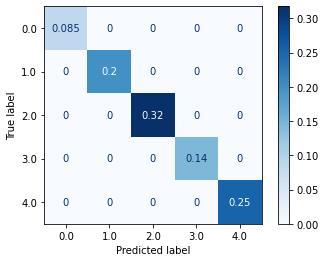

In [19]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(model, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

In [20]:
# binarize/hot-encode here since we look at each class 
lb = LabelBinarizer()
ytest_b = lb.fit_transform(ytest)

precision = dict()
recall = dict()
avg_prec = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(ytest_b[:, i],
                                                        yprob[:, i])
    avg_prec[i] = metrics.average_precision_score(ytest_b[:, i], yprob[:, i])

In [21]:
# "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(ytest_b.ravel(), 
                                                                        yprob.ravel())

In [22]:
avg_prec["micro"] = metrics.average_precision_score(ytest_b, yprob, average="micro")
ap_micro = avg_prec["micro"]
print(f'Average precision score, micro-averaged over all classes: {ap_micro:0.2f}')

Average precision score, micro-averaged over all classes: 0.95


In [23]:
precision

{0: array([0.10278269, 0.10274661, 0.10275074, ..., 1.        , 1.        ,
        1.        ]),
 1: array([0.19949322, 0.19946102, 0.19946905, ..., 1.        , 1.        ,
        1.        ]),
 2: array([0.31912517, 0.31909591, 0.31910962, ..., 1.        , 1.        ,
        1.        ]),
 3: array([0.15846566, 0.15843095, 0.15843749, ..., 1.        , 1.        ,
        1.        ]),
 4: array([0.2609152 , 0.26088417, 0.26089512, ..., 1.        , 1.        ,
        1.        ]),
 'micro': array([0.20089357, 0.20088715, 0.20088877, ..., 1.        , 1.        ,
        1.        ])}

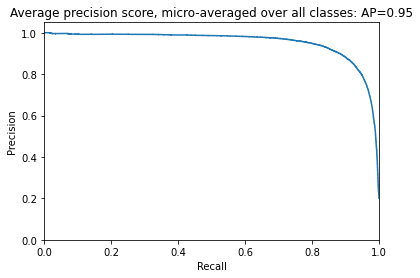

In [24]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Average precision score, micro-averaged over all classes: AP={ap_micro:0.2f}');

### by class and average

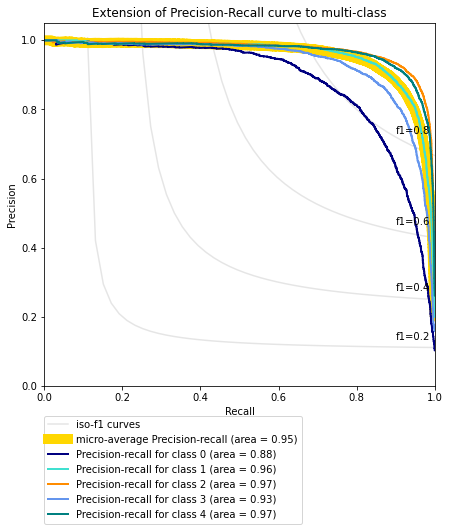

In [25]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=10)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(avg_prec["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, avg_prec[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

### objective="multi:softprob"

all results identical, 

In [26]:
ypred = clf_p.predict(xtest)
ypred

XGBoostError: need to call fit or load_model beforehand

In [ ]:
yprob = clf_p.predict_proba(xtest)
yprob

In [ ]:
assert np.argmax(yprob[0,:]) == ypred[0]
ytest[0]

In [ ]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100}%')

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
b = plot_confusion_matrix(clf, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

In [ ]:
b.figure_

In [ ]:
b

In [ ]:
# binarize/hot-encode here since we look at each class 
lb = LabelBinarizer()
ytest_b = lb.fit_transform(ytest)

precision = dict()
recall = dict()
avg_prec = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = metrics.precision_recall_curve(ytest_b[:, i],
                                                        yprob[:, i])
    avg_prec[i] = metrics.average_precision_score(ytest_b[:, i], yprob[:, i])

In [ ]:
# "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = metrics.precision_recall_curve(ytest_b.ravel(), 
                                                                        yprob.ravel())

In [ ]:
avg_prec["micro"] = metrics.average_precision_score(ytest_b, yprob, average="micro")
ap_micro = avg_prec["micro"]
print(f'Average precision score, micro-averaged over all classes: {ap_micro:0.2f}')

In [ ]:
precision

In [ ]:
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Average precision score, micro-averaged over all classes: AP={ap_micro:0.2f}');

### by class and average

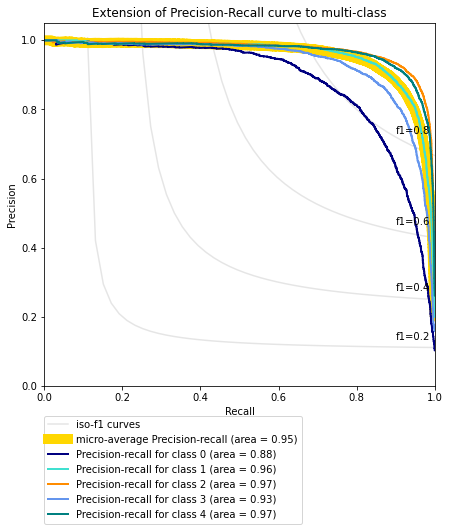

In [27]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=10)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(avg_prec["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, avg_prec[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=10))


plt.show()

### roc curves

In [28]:
key="roc"
plots_dir: str = "plots"
fmt="png"
fpr_label: str = "false positive rate"
tpr_label: str = "true positive rate"
title: str = "roc curve"
legend_loc: str = "best"

In [29]:
# plt.plot([0, 1], [0, 1], "k--")

# # labelling
# plt.xlabel(fpr_label)
# plt.ylabel(tpr_label)
# plt.title(title)
# plt.legend(loc=legend_loc)

# single ROC or mutliple
unique_labels = set(labels)
assert n_classes - len(unique_labels)
is_multiclass = True if len(unique_labels) > 2 else False

if is_multiclass:
    lb = LabelBinarizer()
    ytest_b = lb.fit_transform(ytest)
    # data accummulators by class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = metrics.roc_curve(
            ytest_b[:, i], yprob[:, i], pos_label=1
        )
        roc_auc[i] = metrics.auc(fpr[i], tpr[i])
        #plt.plot(fpr[i], tpr[i], label=f"class {i}")
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = metrics.roc_curve(ytest_b.ravel(), yprob.ravel())
    roc_auc["micro"] = metrics.auc(fpr["micro"], tpr["micro"])
else:
    fpr, tpr, _ = metrics.roc_curve(ytest_b, yprob[:, 1], pos_label=1)
    plt.plot(fpr, tpr, label=f"positive class")

In [30]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  after removing the cwd from sys.path.


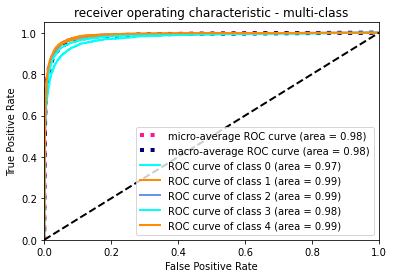

In [31]:
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = metrics.auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('receiver operating characteristic - multi-class')
plt.legend(loc="lower right")
plt.show()

In [32]:
macro_roc_auc_ovo = metrics.roc_auc_score(ytest, yprob, multi_class="ovo",
                                          average="macro")
weighted_roc_auc_ovo = metrics.roc_auc_score(ytest, yprob, multi_class="ovo",
                                             average="weighted")
macro_roc_auc_ovr = metrics.roc_auc_score(ytest, yprob, multi_class="ovr",
                                          average="macro")
weighted_roc_auc_ovr = metrics.roc_auc_score(ytest, yprob, multi_class="ovr",
                                             average="weighted")
print(f"One-vs-One ROC AUC scores:\n{macro_roc_auc_ovo:.6f} (macro),\n{weighted_roc_auc_ovo:.6f} "
      "(weighted by prevalence)")
print(f"One-vs-Rest ROC AUC scores:\n{macro_roc_auc_ovr:.6f} (macro),\n{weighted_roc_auc_ovr:.6f} "
      "(weighted by prevalence)")

One-vs-One ROC AUC scores:
0.981344 (macro),
0.982804 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.983067 (macro),
0.984666 (weighted by prevalence)


## Binary

In [33]:
n_classes = 2

In [34]:
x, labels = make_classification(n_samples=100_000, 
                                n_classes=n_classes, 
                                n_features=40, 
                                weights=[0.4],
                                random_state=rng)

In [35]:
xtrain, xtest, ytrain, ytest = train_test_split(x, labels)

In [36]:
clf = XGBClassifier(n_classes=n_classes, random_state=rng, objective="binary:logistic")

In [37]:
clf.fit(xtrain, ytrain)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_classes=2, n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=3691, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [38]:
ypred = clf.predict(xtest)
yprob = clf.predict_proba(xtest)

In [39]:
error_rate = np.sum(ytest != ypred) / len(ytest)
print(f'{error_rate*100:.2f}%')

4.10%


In [ ]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(clf, xtest, ypred, normalize='all', cmap=plt.cm.Blues);

In [ ]:
metrics.roc_auc_score(ytest, yprob[:,1])

In [ ]:
metrics.accuracy_score(ytest, ypred)

In [ ]:
metrics.f1_score(ytest, ypred)